In [1]:
import os
os.getcwd()

'/content'

In [2]:
if os.getcwd() != '/content/drive/MyDrive/ml_datasets/data':
    os.chdir('/content/drive/MyDrive/ml_datasets/data')

In [3]:
VIOLENT_FILE = os.path.join(os.getcwd(), 'violent_train.txt')
NOT_VIOLENT_FILE = os.path.join(os.getcwd(), 'not_violent_train.txt')

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import random
import unicodedata
import codecs
import itertools
import operator
from io import open
import math
import numpy as np

class NewsMediaDataset(Dataset):
    def __init__(self, v_filename=VIOLENT_FILE, nv_filename=NOT_VIOLENT_FILE, min_length=10):
        self.min_length = min_length
        self.v_articles = self.read_utterances(filename=v_filename)
        self.nv_articles = self.read_utterances(filename=nv_filename)
        self.classes = {"violent": 1, "not_violent": 0}
        self.n_samples = len(self.v_articles) + len(self.nv_articles)
        v_inputs = self.input_generator(self.v_articles)
        nv_inputs = self.input_generator(self.nv_articles)
        self.inputs = v_inputs + nv_inputs
        random.shuffle(self.inputs)

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        article = self.inputs[index][0]
        target = self.inputs[index][1]
        return article, target
    
    def unicodeToAscii(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    def normalizeString(self, s):
        s = self.unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        s = re.sub(r"\s+", r" ", s).strip()
        return s

    def read_utterances(self, filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        articles = [self.normalizeString(l) for l in lines]
        return articles

    def input_generator(self, articles):
        inputs = []
        for article in articles:
            if article in self.v_articles:
                target = self.classes["violent"]
            elif article in self.nv_articles:
                target = self.classes["not_violent"]
            inputs.append([article, target])
        return inputs

In [5]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("device = ", device)

device =  cuda


In [6]:
mediaDataset = NewsMediaDataset()
print('Dataset length : ', len(mediaDataset))

Dataset length :  6244


In [7]:
sentences, targets = [], []

for item in mediaDataset:
    sentences.append(item[0])
    targets.append(item[1])

In [8]:
!pip install transformers

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [10]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (767 > 512). Running this sequence through the model will result in indexing errors


Original:  april a mosque in gorakhpur s bankata village was vandalised and the muezzin was attacked by goons for allegedly giving azaan on a loudspeaker amid lockdown . according to hindustan times reports the incident took place on sunday afternoon under sikriganj police station limit of the district . the trouble begin when the year old muezzin abdul rahman gave the azaan . as soon as the muezzin concluded the call to prayer five to six people barged into the mosque and created ruckus . the attackers thrashed the muezzin and also allegedly desecrated the holy quran and also broke the sound box of the loudspeaker . ali said after hearing the commotion he locked the attackers by closing the door and informed police . in the meantime the attackers came out of the mosque an began abusing and threaten him with dire consequences and went away . later on they came with some more men and attacked ali . when his father azmat ali rushed to his help the goons also beaten azmat who suffered sev

In [11]:
MAX_LEN = 512

from keras.preprocessing.sequence import pad_sequences

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


In [12]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [13]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, targets, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, targets,
                                             random_state=2018, test_size=0.1)

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [15]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


batch_size = 8 # 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False,
    output_hidden_states = False, 
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [20]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [21]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
device

device(type='cuda')

In [24]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        
        model.zero_grad()        

        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        
        loss = outputs[0]

    
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

    
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

    print("")
    print("Running Validation...")

    t0 = time.time()

    
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    
    for batch in validation_dataloader:
        
        
        batch = tuple(t.to(device) for t in batch)
        
        
        b_input_ids, b_input_mask, b_labels = batch
        
        
        with torch.no_grad():        

            
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        logits = outputs[0]

        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        
        eval_accuracy += tmp_eval_accuracy

        
        nb_eval_steps += 1

    
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    703.    Elapsed: 0:00:57.
  Batch    80  of    703.    Elapsed: 0:01:56.
  Batch   120  of    703.    Elapsed: 0:02:54.
  Batch   160  of    703.    Elapsed: 0:03:52.
  Batch   200  of    703.    Elapsed: 0:04:50.
  Batch   240  of    703.    Elapsed: 0:05:49.
  Batch   280  of    703.    Elapsed: 0:06:47.
  Batch   320  of    703.    Elapsed: 0:07:45.
  Batch   360  of    703.    Elapsed: 0:08:43.
  Batch   400  of    703.    Elapsed: 0:09:41.
  Batch   440  of    703.    Elapsed: 0:10:39.
  Batch   480  of    703.    Elapsed: 0:11:37.
  Batch   520  of    703.    Elapsed: 0:12:35.
  Batch   560  of    703.    Elapsed: 0:13:33.
  Batch   600  of    703.    Elapsed: 0:14:32.
  Batch   640  of    703.    Elapsed: 0:15:30.
  Batch   680  of    703.    Elapsed: 0:16:28.

  Average training loss: 0.07
  Training epcoh took: 0:17:01

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:40

======== Epoch 2 / 2 =======

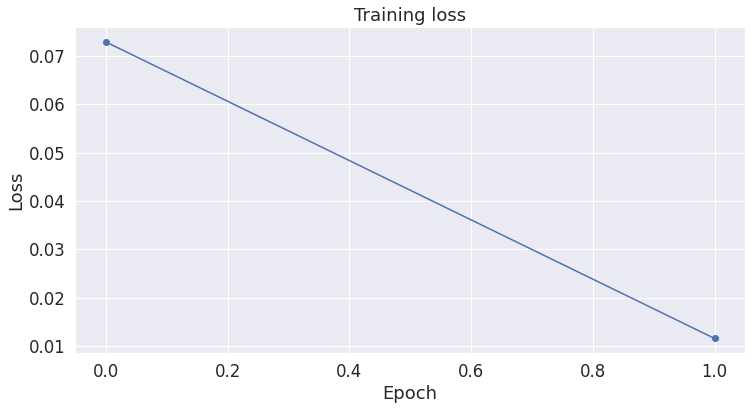

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()